## Proyek Sentiment Analysis

Penganalisisan Sentimen berdasarkan data review dari aplikasi Gojek di Google Play Store.


#### Import Libraries

Mengimport Libraries yang akan digunakan.

In [21]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
 
import datetime as dt
import re 
import string 
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords 
 
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory 
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  
 
from wordcloud import WordCloud 
 
import nltk  
nltk.download('punkt')  
nltk.download('stopwords')  

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\muhst\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\muhst\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Mengload Dataset Hasil Scraping

Mengload hasil scraping ulasan mengenai aplikasi Gojek di Google Play Store. Lalu, melihat datanya.

In [22]:
df = pd.read_csv('gojek_reviews.csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,825e4595-c073-4388-8229-415e372b6c01,Wahyu Pujianti,https://play-lh.googleusercontent.com/a/ACg8oc...,tinggal 2menit lg driver sampe di lokasi tiba-...,1,343,5.14.2,2025-03-26 07:35:56,"Hai Kak Wahyu, mohon maaf atas ketidaknyamanan...",2025-03-26 11:26:47,5.14.2
1,9f871c14-7d44-4f0d-8cbe-9904d42cf3b6,evi puspitasari,https://play-lh.googleusercontent.com/a-/ALV-U...,"Gak usah pasang tarif tarif hemat, soalnya par...",1,527,5.14.2,2025-03-21 21:44:12,"Hai Kak Evi, mohon maaf atas ketidaknyamananny...",2025-03-21 22:05:01,5.14.2
2,cb8f275d-1318-4a5b-b40a-0c33cb89d08a,Michael Giovanni,https://play-lh.googleusercontent.com/a-/ALV-U...,Update aplikasinya malah menyusahkan. Pesan da...,1,193,5.13.1,2025-03-17 05:25:29,"Hai Kak Michael, mohon maaf atas ketidaknyaman...",2025-03-17 07:18:53,5.13.1
3,f2c6b9c3-6014-4126-b7aa-96edb9c6efe8,Aminatul Mardhiyyah,https://play-lh.googleusercontent.com/a/ACg8oc...,"aplikasi kikir 😡, pelit bgt ngasih diskon buat...",1,3,5.18.2,2025-05-17 14:34:58,"Hai Aminatul Mardhiyyah, mohon maaf untuk kend...",2022-09-04 10:35:15,5.18.2
4,9c7666d3-17e4-4ce7-bc97-70f42afc4af0,Hanni Njeans,https://play-lh.googleusercontent.com/a/ACg8oc...,"Untuk sekarang, sudah membaik. Aku ada saran, ...",3,1,5.18.2,2025-05-17 09:27:44,"Hai Kak Hanni, mohon maaf atas ketidaknyamanan...",2025-05-17 15:11:06,5.18.2


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              30000 non-null  object
 1   userName              30000 non-null  object
 2   userImage             30000 non-null  object
 3   content               30000 non-null  object
 4   score                 30000 non-null  int64 
 5   thumbsUpCount         30000 non-null  int64 
 6   reviewCreatedVersion  24700 non-null  object
 7   at                    30000 non-null  object
 8   replyContent          13744 non-null  object
 9   repliedAt             13744 non-null  object
 10  appVersion            24700 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.5+ MB


In [24]:
df = df.dropna()
df = df.drop_duplicates()
jumlah_ulasan_setelah_hapus_duplikat, jumlah_kolom_setelah_hapus_duplikat = df.shape
df.shape

(11196, 11)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11196 entries, 0 to 29996
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              11196 non-null  object
 1   userName              11196 non-null  object
 2   userImage             11196 non-null  object
 3   content               11196 non-null  object
 4   score                 11196 non-null  int64 
 5   thumbsUpCount         11196 non-null  int64 
 6   reviewCreatedVersion  11196 non-null  object
 7   at                    11196 non-null  object
 8   replyContent          11196 non-null  object
 9   repliedAt             11196 non-null  object
 10  appVersion            11196 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.0+ MB


#### Data Preprocessing

Mengpreprocess data sebelum dianalisis dan digunakan untuk model.

##### Penghapusan kolom yang tidak digunakan

In [26]:
df = df.drop(columns=['reviewId', 'userImage', 'thumbsUpCount', 'reviewCreatedVersion', 'replyContent',
                      'repliedAt', 'appVersion'])
print(df.columns)

Index(['userName', 'content', 'score', 'at'], dtype='object')


In [27]:
df

,userName,content,score,at
0,Wahyu Pujianti,tinggal 2menit lg driver sampe di lokasi tiba-...,1,2025-03-26 07:35:56
1,evi puspitasari,"Gak usah pasang tarif tarif hemat, soalnya par...",1,2025-03-21 21:44:12
2,Michael Giovanni,Update aplikasinya malah menyusahkan. Pesan da...,1,2025-03-17 05:25:29
3,Aminatul Mardhiyyah,"aplikasi kikir 😡, pelit bgt ngasih diskon buat...",1,2025-05-17 14:34:58
4,Hanni Njeans,"Untuk sekarang, sudah membaik. Aku ada saran, ...",3,2025-05-17 09:27:44
...,...,...,...,...
29989,Sella Nurbayanti,Susah cari driver padahal banyak driver yang d...,3,2022-09-30 11:16:59
29991,Pengguna Google,apaan kalo mesan dapetnya driver jauh jauh..su...,1,2021-08-06 20:38:27
29994,Ika Wina,Saya kecewa banget sama gojek udah sering bang...,1,2021-10-23 20:47:45
29995,Erwin Rommel,Dah 2 kali lokasi gak akurat malah melambung j...,1,2022-05-25 15:57:08


##### Cleaning Text

In [28]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka
 
    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text
 
def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text
 
def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text
 
def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy", "yg"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text
 
def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
 
    # Memecah teks menjadi daftar kata
    words = text.split()
 
    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]
 
    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)
 
    return stemmed_text
 
def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

slangwords = {
    "@": "di",
    "abis": "habis",
    "wtb": "beli",
    "masi": "masih",
    "wts": "jual",
    "wtt": "tukar",
    "bgt": "banget",
    "maks": "maksimal",
    "tp": "tapi",
    "krn": "karena",
    "dr": "dari",
    "jg": "juga",
    "udh": "sudah",
    "sdh": "sudah",
    "blm": "belum",
    "dgn": "dengan",
    "ga": "tidak",
    "gak": "tidak",
    "nggak": "tidak",
    "aja": "saja",
    "klo": "kalau",
    "kl": "kalau",
    "dl": "dulu",
    "sm": "sama",
    "cm": "cuma",
    "bbrp": "beberapa",
    "lg": "lagi",
    "bgt": "banget",
    "trs": "terus",
    "sy": "saya",
    "gw": "saya",
    "loe": "kamu",
    "lu": "kamu",
    "lo": "kamu",
    "udah": "sudah",
    "bisa": "dapat",
    "tdk": "tidak",
    "bkn": "bukan",
    "gk": "tidak",
    "gitu": "begitu",
    "gimana": "bagaimana",
    "gmn": "bagaimana"
}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []
 
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
 
    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [29]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
df['text_clean'] = df['content'].apply(cleaningText)
 
# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
df['text_casefoldingText'] = df['text_clean'].apply(casefoldingText)
 
# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)
 
# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
df['text_tokenizingText'] = df['text_slangwords'].apply(tokenizingText)
 
# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
df['text_stopword'] = df['text_tokenizingText'].apply(filteringText)
 
# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
df['text_akhir'] = df['text_stopword'].apply(toSentence)

In [30]:
df.to_csv("data_preprocessed.csv")

#### Data Labelling

In [31]:
import csv
import requests
from io import StringIO
 
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()
 
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub
 
if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma
 
    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")
 
# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()
 
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub
 
if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma
 
    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

In [32]:
def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:
 
    score = 0
    # Inisialisasi skor sentimen ke 0
 
    for word in text:
        # Mengulangi setiap kata dalam teks
 
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen
 
    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)
 
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen
 
    polarity=''
    # Inisialisasi variabel polaritas
 
    if (score > 0):
        polarity = 'positive'
        # Jika skor sentimen lebih besar atau sama dengan 0, maka polaritas adalah positif
    elif (score < 0):
        polarity = 'negative'
        # Jika skor sentimen kurang dari 0, maka polaritas adalah negatif
 
    else:
        polarity = 'neutral'
    # Ini adalah bagian yang bisa digunakan untuk menentukan polaritas netral jika diperlukan
 
    return score, polarity

In [33]:
results = df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df['polarity_score'] = results[0]
df['polarity'] = results[1]
print(df['polarity'].value_counts())

polarity
negative    7030
positive    3504
neutral      662
Name: count, dtype: int64


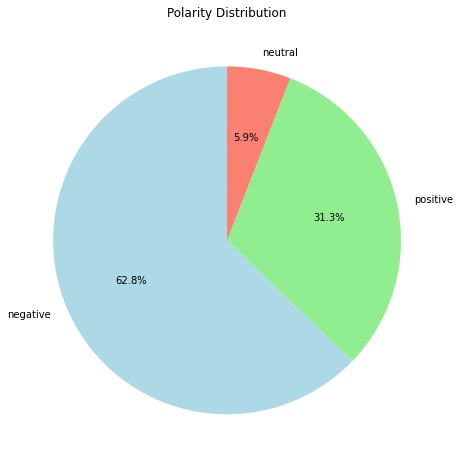

In [34]:
# Count the occurrences of each polarity
polarity_counts = df['polarity'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))
polarity_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen', 'salmon'])
plt.title('Polarity Distribution')
plt.ylabel('')  # Remove y-axis label for better visualization
plt.show()

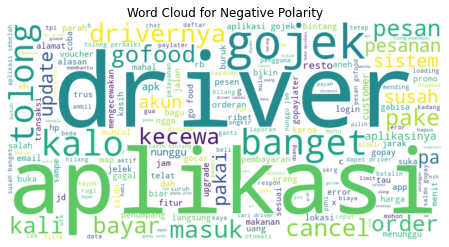

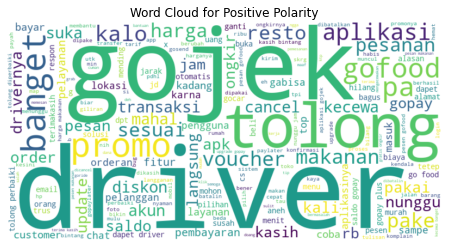

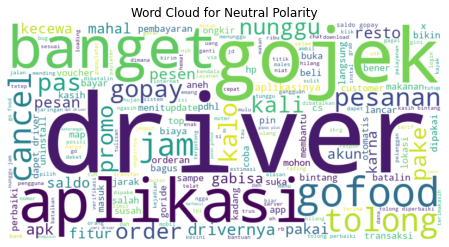

In [35]:
from wordcloud import WordCloud

for polarity in df['polarity'].unique():
    text = ' '.join(df[df['polarity'] == polarity]['text_akhir'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Plot the word cloud
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {polarity.capitalize()} Polarity')
    plt.axis('off')
    plt.show()

#### Model

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


# Pisahkan data menjadi fitur (tweet) dan label (sentimen)
X = df['text_akhir']
y = df['polarity']

# Ekstraksi fitur dengan TF-IDF (dengan n-grams)
tfidf = TfidfVectorizer(max_features=5000, min_df=2, max_df=0.9, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(X)

# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)


# Skema 1 : TF-IDF NaiveBayes 80/20

In [37]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
 
# Hyperparameter tuning for Naive Bayes
param_grid = {'alpha': [0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}

# Menggunakan Multinomial Naive Bayes (lebih cocok untuk TF-IDF)
naive_bayes = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
naive_bayes.fit(X_train, y_train)

# Melakukan prediksi
y_pred_train_nb = naive_bayes.predict(X_train)
y_pred_test_nb = naive_bayes.predict(X_test)

# Evaluasi akurasi model Naive Bayes
accuracy_train_nb = accuracy_score(y_pred_train_nb, y_train)
accuracy_test_nb = accuracy_score(y_pred_test_nb, y_test)

# Menampilkan akurasi
print('Optimized Naive Bayes - accuracy_train:', accuracy_train_nb)
print('Optimized Naive Bayes - accuracy_test:', accuracy_test_nb)
print('Best alpha:', naive_bayes.best_params_)

Optimized Naive Bayes - accuracy_train: 0.8350133979839224
Optimized Naive Bayes - accuracy_test: 0.7475439118785353
Best alpha: {'alpha': 0.1}


# Skema 2

In [20]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical


# Tokenisasi
max_features = 2500
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X)

# Label encoding untuk target y
labelencoder = LabelEncoder()
integer_encoded = labelencoder.fit_transform(y)
y = to_categorical(integer_encoded)

# Menentukan jumlah kelas
num_classes = y.shape[1]

print("Shape of tokenized sequences:", X.shape)
print("Shape of target labels:", y.shape)
print("Number of classes:", num_classes)

KeyboardInterrupt: 

In [19]:
# Membagi dataset: 10% untuk uji, sisanya untuk train+validation
X_train_val, X_test_LSTM, y_train_val, y_test_LSTM = train_test_split(X, y, test_size=0.1, random_state=42)

# Dari train+validation, ambil 20% sebagai validation (total: 70% training, 20% validation, 10% testing)
X_train_LSTM, X_val_LSTM, y_train_LSTM, y_val_LSTM = train_test_split(X_train_val, y_train_val, test_size=2/9, random_state=42)

print("Shape X_train_LSTM:", X_train_LSTM.shape)
print("Shape X_val_LSTM:", X_val_LSTM.shape)
print("Shape X_test_LSTM:", X_test_LSTM.shape)

Shape X_train_LSTM: (5967, 57)
Shape X_val_LSTM: (1705, 57)
Shape X_test_LSTM: (853, 57)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Membangun model LSTM
model_LSTM = Sequential()
model_LSTM.add(Embedding(max_features, 256, input_length=X.shape[1]))
model_LSTM.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01), return_sequences=True))
model_LSTM.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))
model_LSTM.add(Dense(128, activation='relu'))
model_LSTM.add(Dense(64, activation='relu'))
model_LSTM.add(Dense(num_classes, activation='softmax'))

model_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

batch_size = 2056
history_LSTM = model_LSTM.fit(
    X_train_LSTM, y_train_LSTM,
    epochs=50,
    batch_size=batch_size,
    verbose=2,
    callbacks=[
        EarlyStopping(
            monitor='accuracy',
            patience=3,
            restore_best_weights=True
        )
    ],
    validation_data=(X_val_LSTM, y_val_LSTM)
)

# Evaluasi model pada data uji
score_LSTM, acc_LSTM = model_LSTM.evaluate(X_test_LSTM, y_test_LSTM, verbose=2)
print("Test score: %.2f" % score_LSTM)
print("Test accuracy: %.2f" % acc_LSTM)

Epoch 1/50




ResourceExhaustedError: Graph execution error:

Detected at node sequential_1/lstm_3/while/lstm_cell/dropout/SelectV2 defined at (most recent call last):
  File "c:\Program Files\python310\lib\runpy.py", line 196, in _run_module_as_main

  File "c:\Program Files\python310\lib\runpy.py", line 86, in _run_code

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Program Files\python310\lib\asyncio\base_events.py", line 600, in run_forever

  File "c:\Program Files\python310\lib\asyncio\base_events.py", line 1896, in _run_once

  File "c:\Program Files\python310\lib\asyncio\events.py", line 80, in _run

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code

  File "C:\Users\muhst\AppData\Local\Temp\ipykernel_15004\1019939484.py", line 20, in <cell line: 20>

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 1807, in fit

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 1401, in train_function

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 1384, in step_function

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 1373, in run_step

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 1150, in train_step

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\sequential.py", line 398, in call

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\functional.py", line 515, in call

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\base_rnn.py", line 556, in __call__

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\lstm.py", line 626, in call

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\backend.py", line 5168, in rnn

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\backend.py", line 5147, in _step

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\lstm.py", line 624, in step

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\lstm.py", line 279, in call

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\dropout_rnn_cell_mixin.py", line 129, in get_dropout_mask_for_cell

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\backend.py", line 7554, in setdefault

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\dropout_rnn_cell_mixin.py", line 93, in _create_dropout_mask

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\dropout_rnn_cell_mixin.py", line 175, in _generate_dropout_mask

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\dropout_rnn_cell_mixin.py", line 176, in <listcomp>

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\backend.py", line 5310, in in_train_phase

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\dropout_rnn_cell_mixin.py", line 172, in dropped_inputs

  File "C:\Users\muhst\AppData\Roaming\Python\Python310\site-packages\keras\src\backend.py", line 2170, in dropout

OOM when allocating tensor with shape[2056,128] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[{{node sequential_1/lstm_3/while/lstm_cell/dropout/SelectV2}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_9610]